In [121]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matyplotlib -rf

Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [122]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random

sns.set_style("whitegrid")

BASE = Path.cwd().parents[1] / "python-server" / "app" / "data_pipeline"

eval_df = pd.read_csv(BASE/"eval_2025_pred_vs_actual.csv", parse_dates=["target_date"])
pred_df = pd.read_csv(BASE/"predictions.csv", parse_dates=["target_date"])
fea_df  = pd.read_csv(BASE/"features_all.csv", parse_dates=["target_date"])
sku_info = pd.read_csv(BASE/"sku_catalog_ml_with_share.csv")


In [124]:
# eval: actual(y), pred_lgb(y_pred)
eval_df = eval_df.rename(columns={"y":"actual", "y_pred":"pred_lgb"})

pred_df = pred_df.rename(columns={"y_pred":"pred_ens"})

df = eval_df.merge(
    pred_df[["sku_id","target_date","pred_ens"]],
    on=["sku_id","target_date"],
    how="left"
)

df = df.merge(
    sku_info[["sku_id","cat_low"]],
    on="sku_id",
    how="left"
)

df.dropna(subset=["pred_ens"], inplace=True)
df.head()


,target_date,sku_id,actual,pred_lgb,pred_ens,cat_low
49,2025-12-15,1,44,44.950013,40.0,TV
50,2025-12-22,1,42,43.810135,40.0,TV
51,2025-12-29,1,35,40.958146,41.0,TV
101,2025-12-15,2,2,2.151419,2.0,TV
102,2025-12-22,2,2,2.134132,2.0,TV


In [125]:
def mape(a, f):
    a, f = np.array(a), np.array(f)
    return np.mean(np.abs((a - f) / np.maximum(a, 1))) * 100

# MAE
mae_lgb = np.mean(np.abs(df["actual"] - df["pred_lgb"]))
mae_ens = np.mean(np.abs(df["actual"] - df["pred_ens"]))

# MAPE
mape_lgb = mape(df["actual"], df["pred_lgb"])
mape_ens = mape(df["actual"], df["pred_ens"])

print("=== 전체 성능 비교 ===")
print(f"LightGBM MAE  : {mae_lgb:.3f}")
print(f"Ensemble MAE  : {mae_ens:.3f}")
print(f"LightGBM MAPE : {mape_lgb:.3f}%")
print(f"Ensemble MAPE : {mape_ens:.3f}%")


=== 전체 성능 비교 ===
LightGBM MAE  : 2.521
Ensemble MAE  : 2.121
LightGBM MAPE : 14.646%
Ensemble MAPE : 7.190%


In [93]:
cat_mape = (
    df.groupby("cat_low")
      .apply(lambda g: mape(g["actual"], g["pred_ens"]))
      .reset_index(name="MAPE_ens")
)

cat_mape_lgb = (
    df.groupby("cat_low")
      .apply(lambda g: mape(g["actual"], g["pred_lgb"]))
      .reset_index(name="MAPE_lgb")
)

cat_compare = cat_mape.merge(cat_mape_lgb, on="cat_low")
cat_compare["Improved"] = cat_compare["MAPE_lgb"] - cat_compare["MAPE_ens"]

cat_compare


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_37076\3771457524.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mape(g["actual"], g["pred_ens"]))
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_37076\3771457524.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mape(g["actual"], g["pred_lgb"]))


,cat_low,MAPE_ens,MAPE_lgb,Improved
0,TV,4.753982,6.366355,1.612373
1,건조기,1.736454,25.197191,23.460737
2,공기청정기,3.139599,8.393383,5.253784
3,냉장고,1.212550,16.924209,15.711659
4,노트북,2.850453,7.138012,4.287559
5,데스크탑,12.346823,21.276174,8.929351
6,라우터,2.492380,2.571718,0.079338
7,모니터,16.877795,17.184197,0.306402
8,믹서기,16.748695,14.974373,-1.774322
9,세탁기,4.141506,24.809370,20.667864


In [126]:
sku_stats = (
    df.groupby("sku_id")
      .apply(lambda g: pd.Series({
          "mape_lgb": mape(g["actual"], g["pred_lgb"]),
          "mape_ens": mape(g["actual"], g["pred_ens"])
      }))
).reset_index()

sku_stats["improved"] = sku_stats["mape_lgb"] > sku_stats["mape_ens"]

print("향상된 SKU 개수:", sku_stats["improved"].sum())
print("악화된 SKU 개수:", (~sku_stats["improved"]).sum())
print("향상 비율       :", sku_stats["improved"].mean())


향상된 SKU 개수: 156
악화된 SKU 개수: 50
향상 비율       : 0.7572815533980582


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_37076\3962769739.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [95]:
total_sales = df.groupby("sku_id")["actual"].sum().reset_index(name="total_sales")

merged_sku = sku_stats.merge(total_sales, on="sku_id")
merged_sku["group"] = pd.qcut(merged_sku["total_sales"], q=4, labels=["Low","Medium","High","Very High"])

merged_sku.groupby("group")["improved"].mean()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_37076\3800377836.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_sku.groupby("group")["improved"].mean()


group
Low          1.000000
Medium       0.826087
High         0.596154
Very High    0.588235
Name: improved, dtype: float64

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_37076\4211947663.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["err_lgb"], label="LGBM", shade=True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_37076\4211947663.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["err_ens"], label="Ensemble", shade=True)


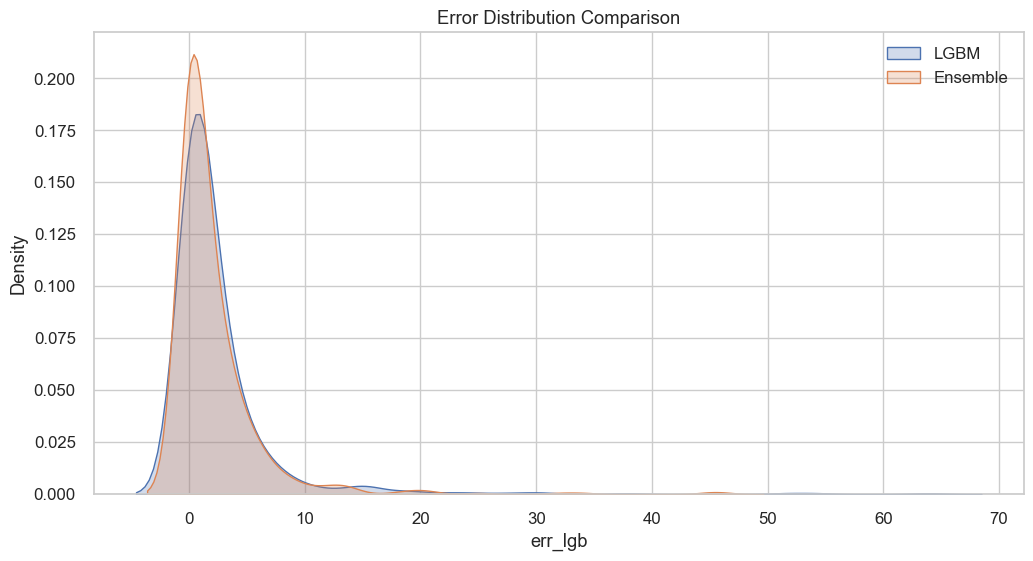

In [96]:
df["err_lgb"] = np.abs(df["actual"] - df["pred_lgb"])
df["err_ens"] = np.abs(df["actual"] - df["pred_ens"])

plt.figure(figsize=(12,6))
sns.kdeplot(df["err_lgb"], label="LGBM", shade=True)
sns.kdeplot(df["err_ens"], label="Ensemble", shade=True)
plt.title("Error Distribution Comparison")
plt.legend()
plt.show()


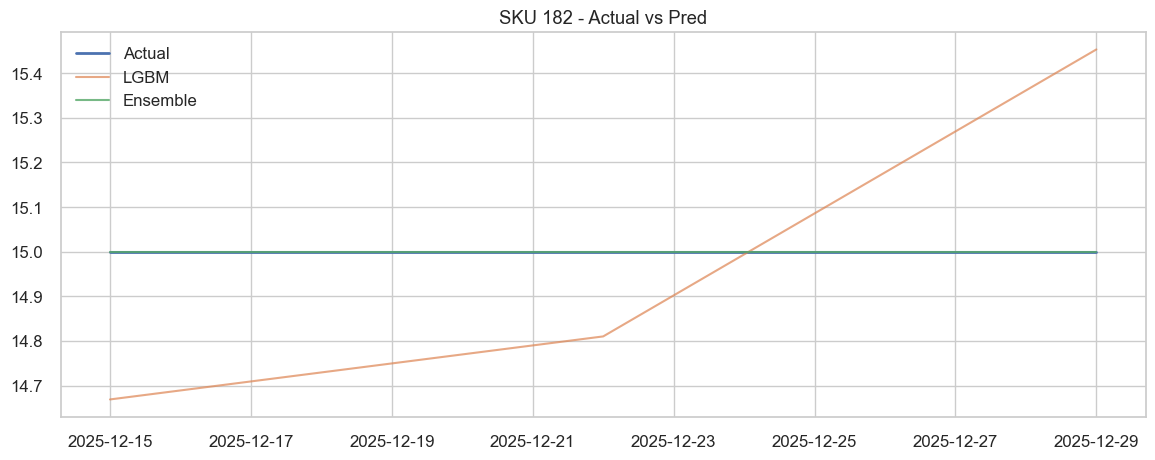

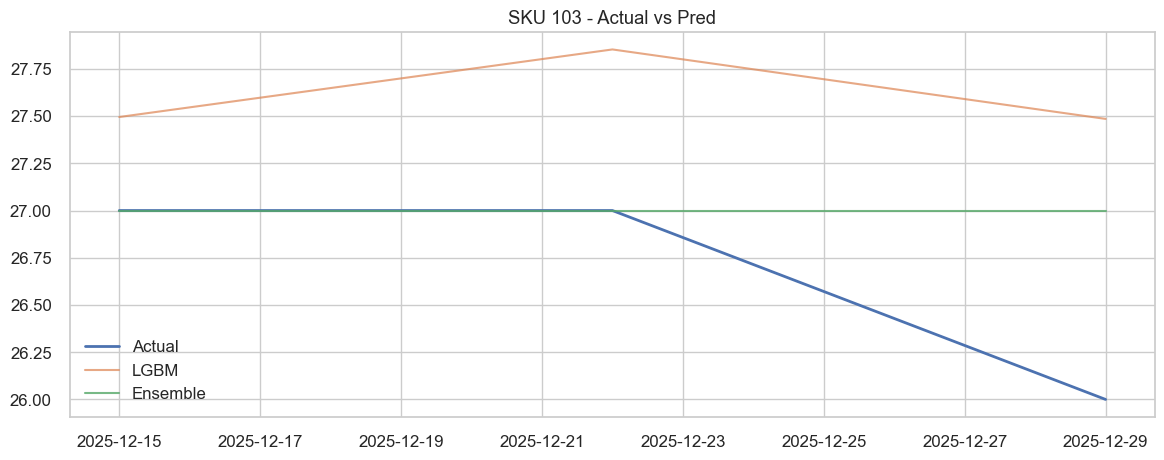

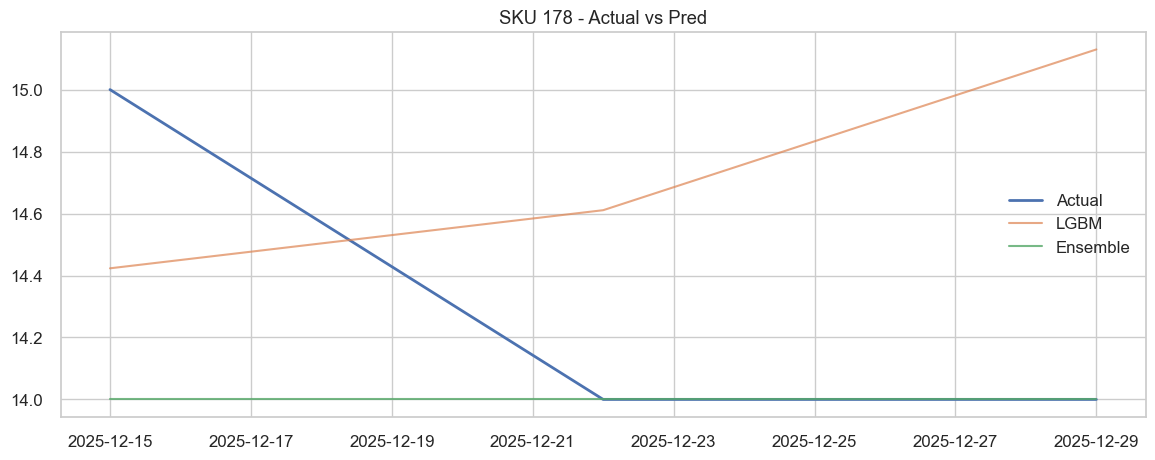

In [97]:
sample_skus = random.sample(df["sku_id"].unique().tolist(), 3)

for sku in sample_skus:
    sub = df[df["sku_id"] == sku].sort_values("target_date")

    plt.figure(figsize=(14,5))
    plt.plot(sub["target_date"], sub["actual"], label="Actual", linewidth=2)
    plt.plot(sub["target_date"], sub["pred_lgb"], label="LGBM", alpha=0.7)
    plt.plot(sub["target_date"], sub["pred_ens"], label="Ensemble", alpha=0.8)

    plt.title(f"SKU {sku} - Actual vs Pred")
    plt.legend()
    plt.grid(True)
    plt.show()


C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


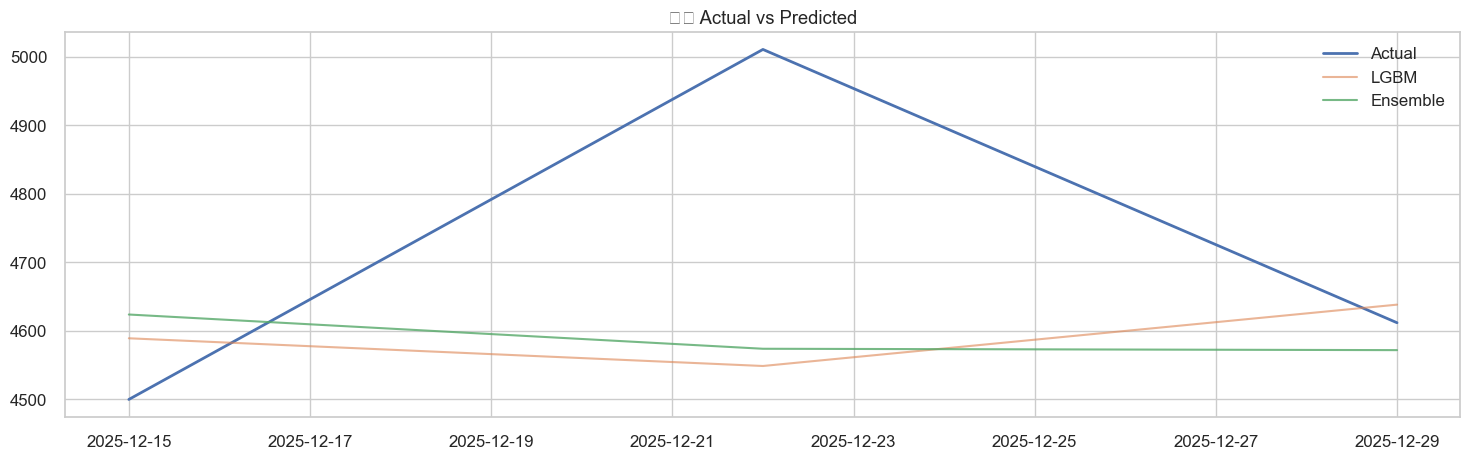

In [98]:
ts = df.groupby("target_date").agg(
    actual_sum=("actual","sum"),
    pred_lgb_sum=("pred_lgb","sum"),
    pred_ens_sum=("pred_ens","sum"),
).reset_index()

plt.figure(figsize=(18,5))
plt.plot(ts["target_date"], ts["actual_sum"], label="Actual", linewidth=2)
plt.plot(ts["target_date"], ts["pred_lgb_sum"], label="LGBM", alpha=0.6)
plt.plot(ts["target_date"], ts["pred_ens_sum"], label="Ensemble", alpha=0.8)
plt.title("전체 Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import random

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

BASE = Path.cwd().parents[1] / "python-server" / "app" / "data_pipeline"


SKU_PATH = BASE / "sku_catalog_ml_with_share.csv"
SALES_PATH = BASE / "weekly_sales.csv"
FEATURES_PATH = BASE / "features_all.csv"
PRED_PATH = BASE / "eval_2025_pred_vs_actual.csv"  

print(SKU_PATH, SALES_PATH, FEATURES_PATH, PRED_PATH)


C:\Users\chosw\ORDER101_251_AI_RE\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\sku_catalog_ml_with_share.csv C:\Users\chosw\ORDER101_251_AI_RE\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\weekly_sales.csv C:\Users\chosw\ORDER101_251_AI_RE\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\features_all.csv C:\Users\chosw\ORDER101_251_AI_RE\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\eval_2025_pred_vs_actual.csv


In [100]:
df_sku = pd.read_csv(SKU_PATH)
df_sales = pd.read_csv(SALES_PATH, parse_dates=["target_date"])
df_feat = pd.read_csv(FEATURES_PATH, parse_dates=["target_date"])
df_pred = pd.read_csv(PRED_PATH, parse_dates=["target_date"])

print("SKU rows:", len(df_sku))
print("Sales rows:", len(df_sales))
print("Features rows:", len(df_feat))
print("Pred rows:", len(df_pred))

df_sales.head()


SKU rows: 206
Sales rows: 53766
Features rows: 51294
Pred rows: 10712


,target_date,warehouse_id,store_id,sku_id,actual_order_qty
0,2021-01-04,1,1,1,0
1,2021-01-04,1,1,2,0
2,2021-01-04,1,1,3,0
3,2021-01-04,1,1,4,0
4,2021-01-04,1,1,5,0


C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtool

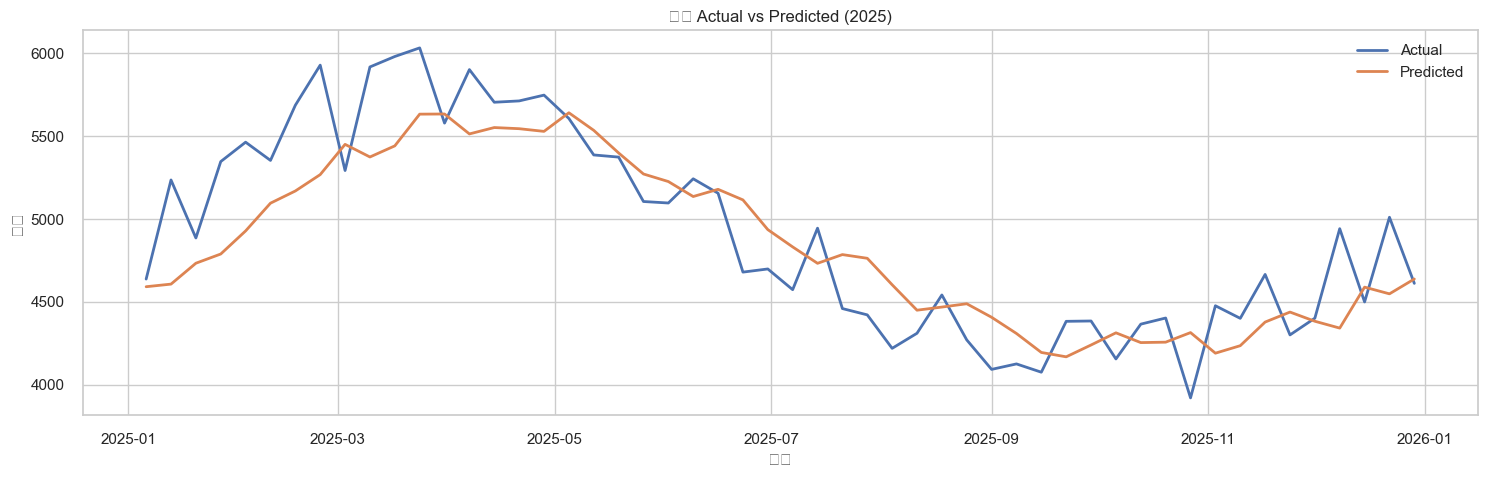

In [127]:
ts_pred = (
    df_pred.groupby("target_date")[["y", "y_pred"]]
    .sum()
    .reset_index()
)

plt.figure(figsize=(18,5))
plt.plot(ts_pred["target_date"], ts_pred["y"], label="Actual", linewidth=2)
plt.plot(ts_pred["target_date"], ts_pred["y_pred"], label="Predicted", linewidth=2)
plt.title("전체 Actual vs Predicted (2025)")
plt.xlabel("날짜")
plt.ylabel("수량")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.p

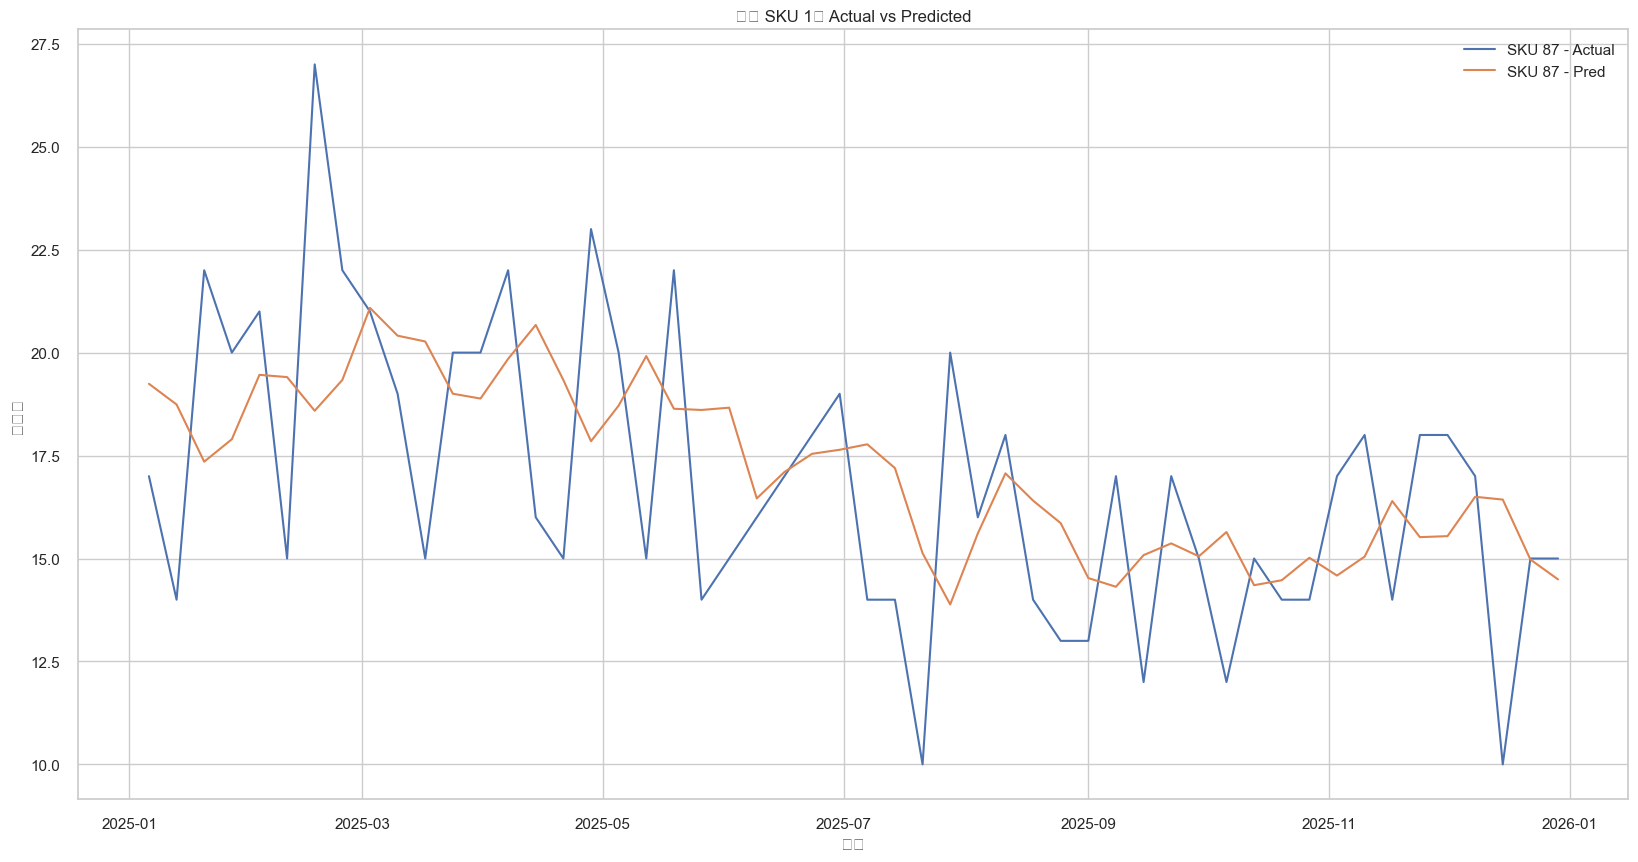

[87]

In [128]:
sample_skus_pred = random.sample(df_pred["sku_id"].unique().tolist(), 1)

plt.figure(figsize=(20,10))

for sku in sample_skus_pred:
    sub = df_pred[df_pred["sku_id"] == sku]
    plt.plot(sub["target_date"], sub["y"], label=f"SKU {sku} - Actual")
    plt.plot(sub["target_date"], sub["y_pred"], label=f"SKU {sku} - Pred")

plt.title("임의 SKU 1개 Actual vs Predicted")
plt.xlabel("날짜")
plt.ylabel("판매량")
plt.legend()
plt.grid(True)
plt.show()

sample_skus_pred


C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


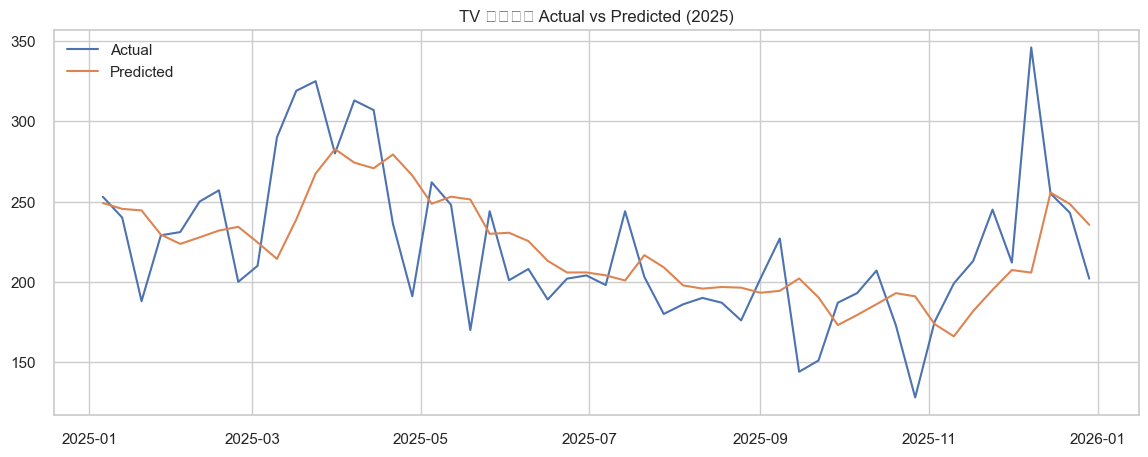

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


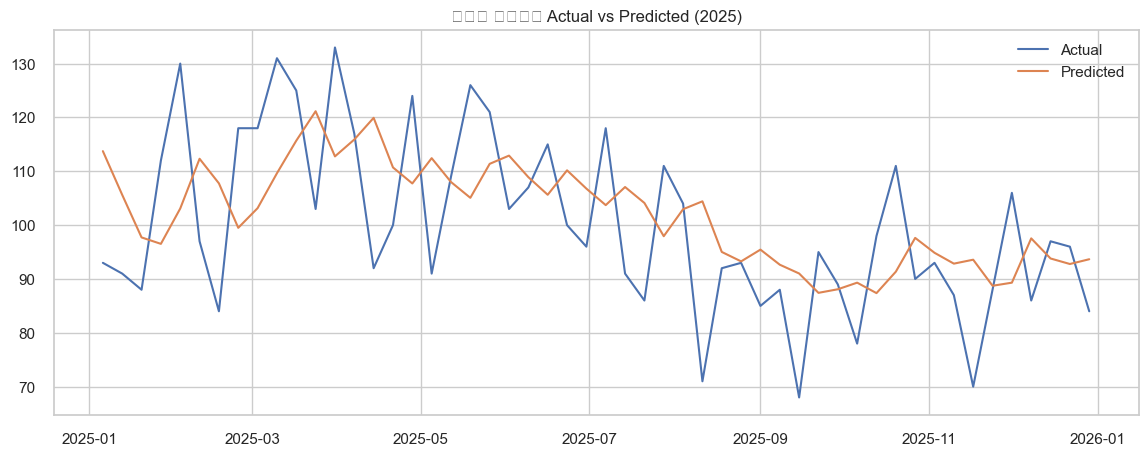

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


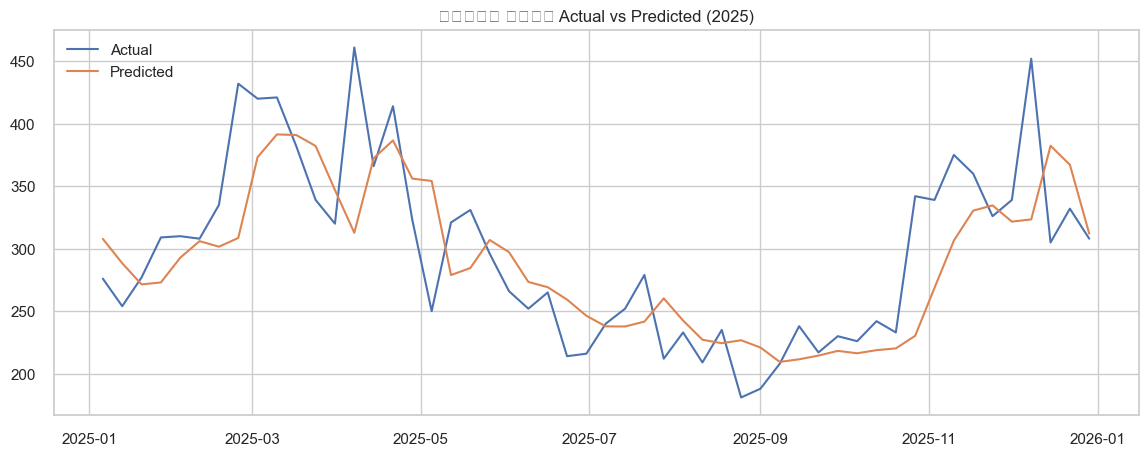

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45257 (\N{HANGUL SYLLABLE NAENG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


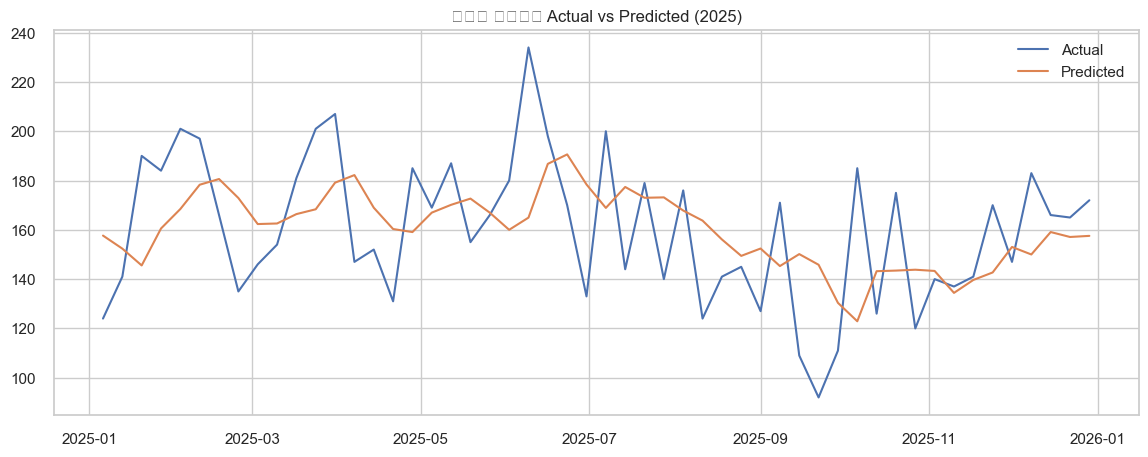

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


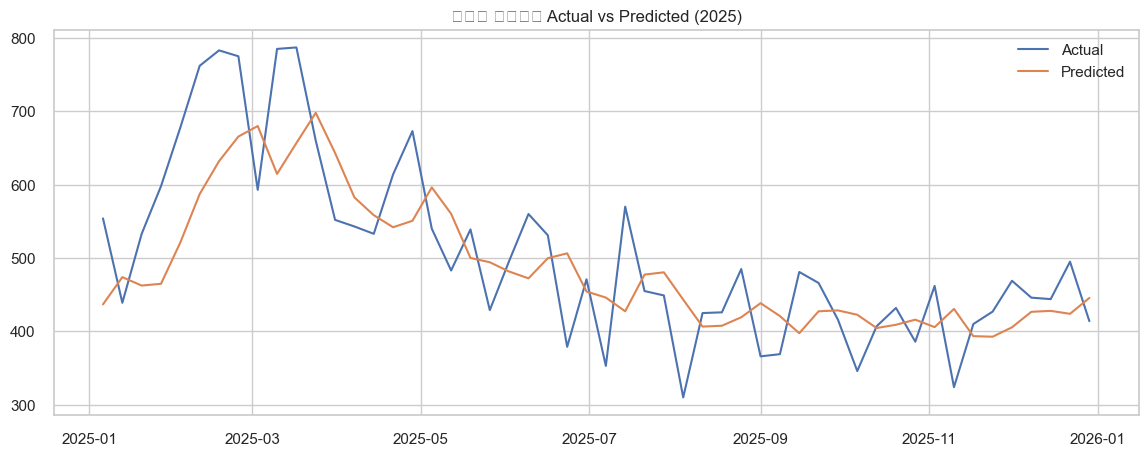

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53457 (\N{HANGUL SYLLABLE TAB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


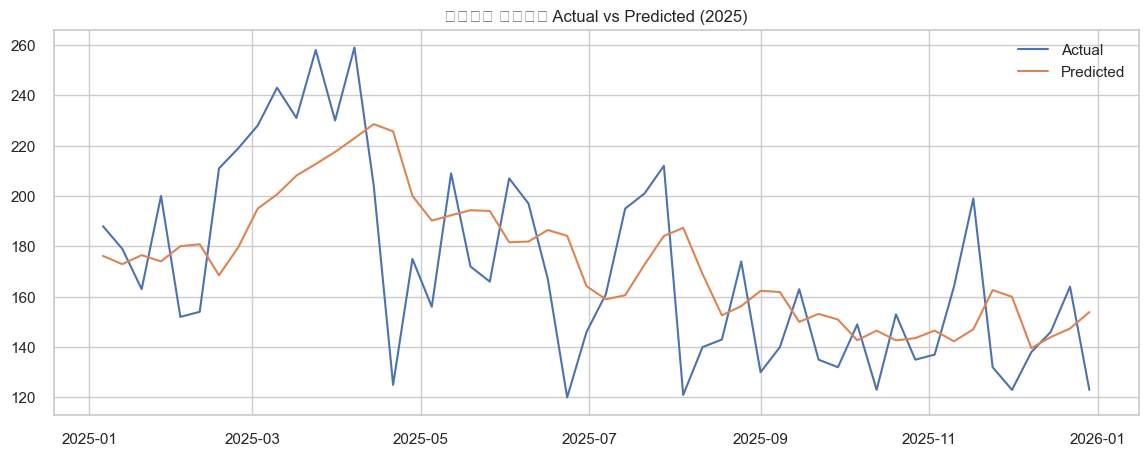

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


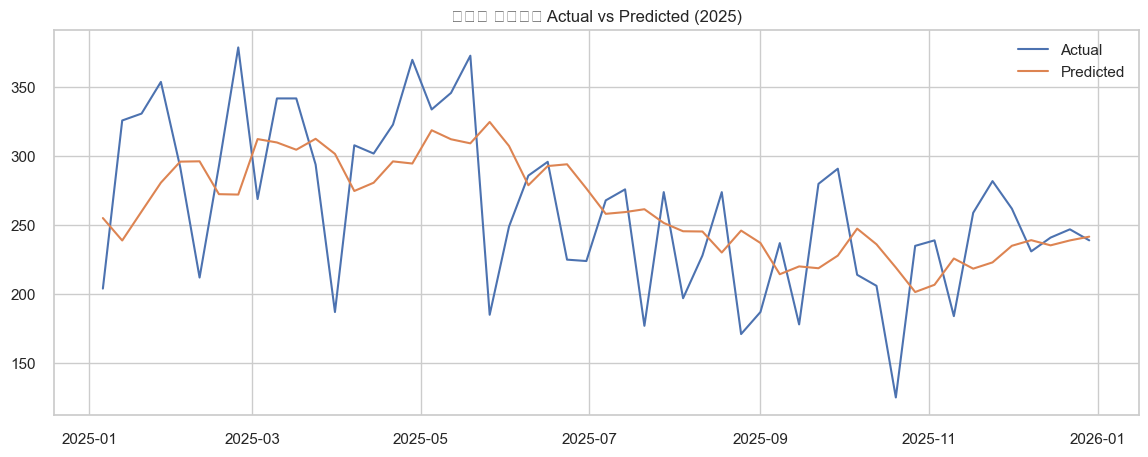

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45768 (\N{HANGUL SYLLABLE NI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


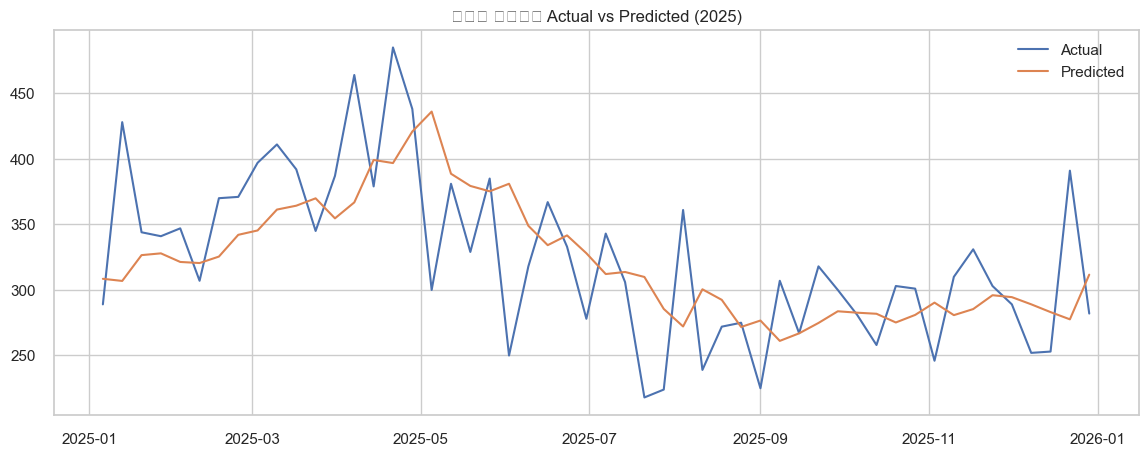

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48121 (\N{HANGUL SYLLABLE MIG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


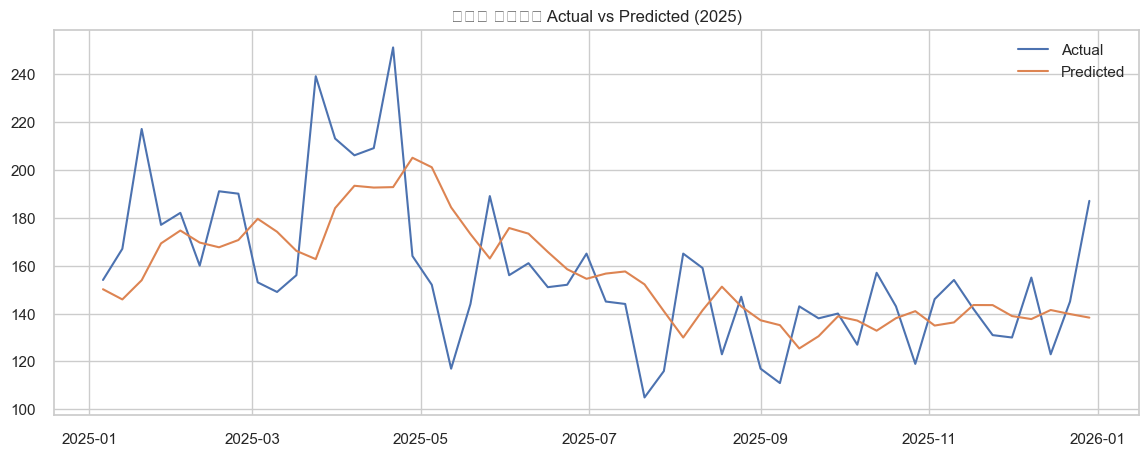

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53441 (\N{HANGUL SYLLABLE TAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


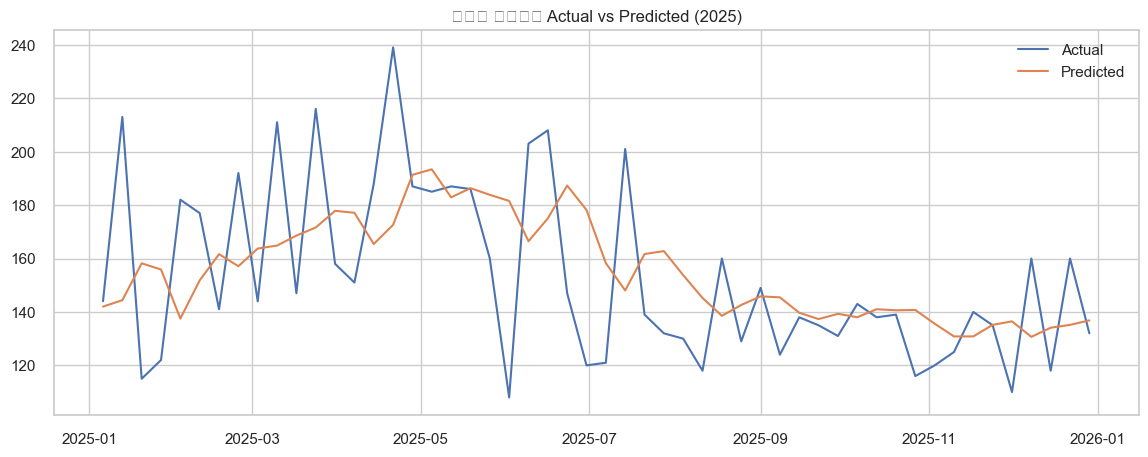

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


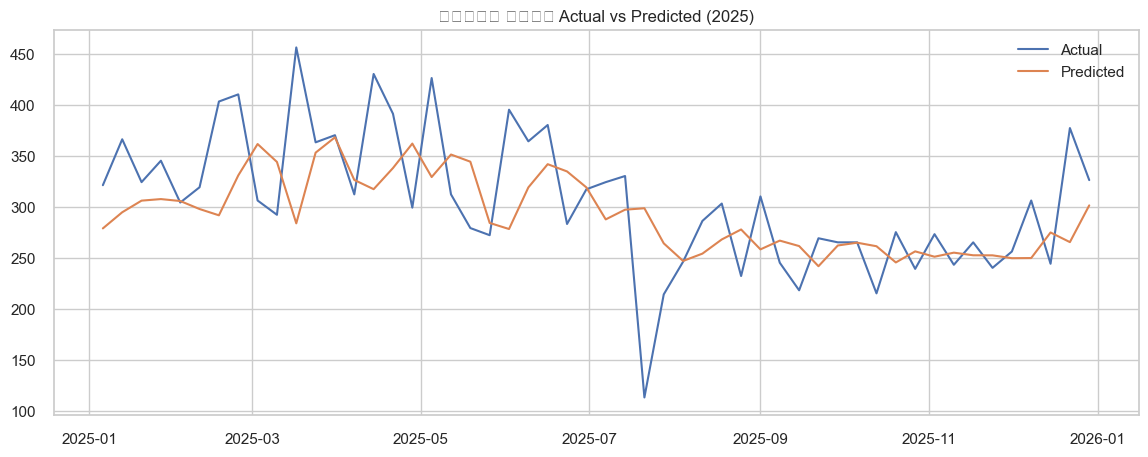

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54256 (\N{HANGUL SYLLABLE PON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


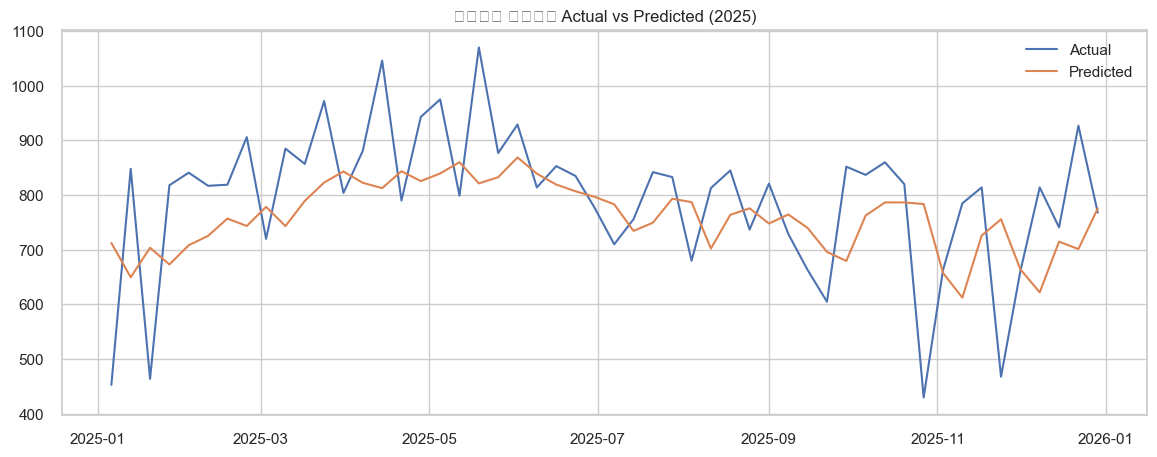

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52377 (\N{HANGUL SYLLABLE CEOG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


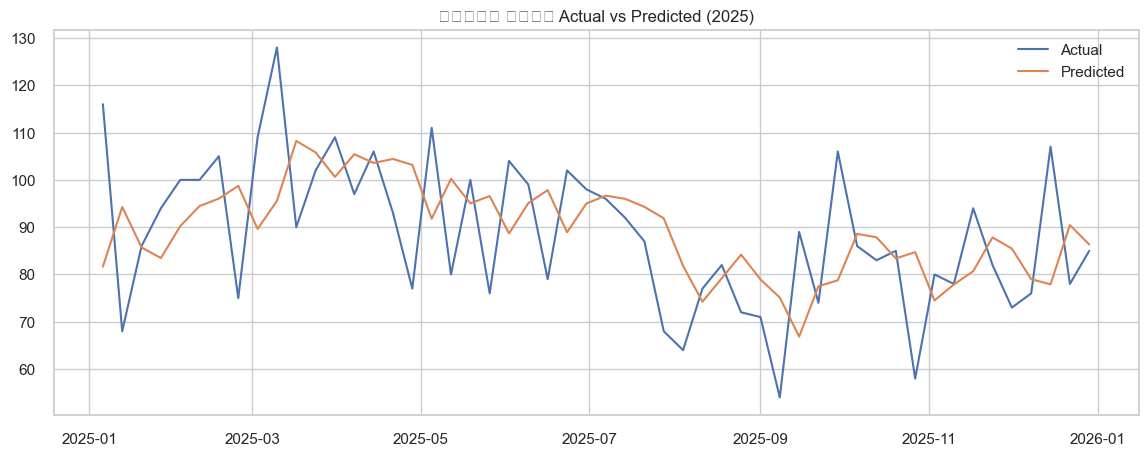

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52968 (\N{HANGUL SYLLABLE KEON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


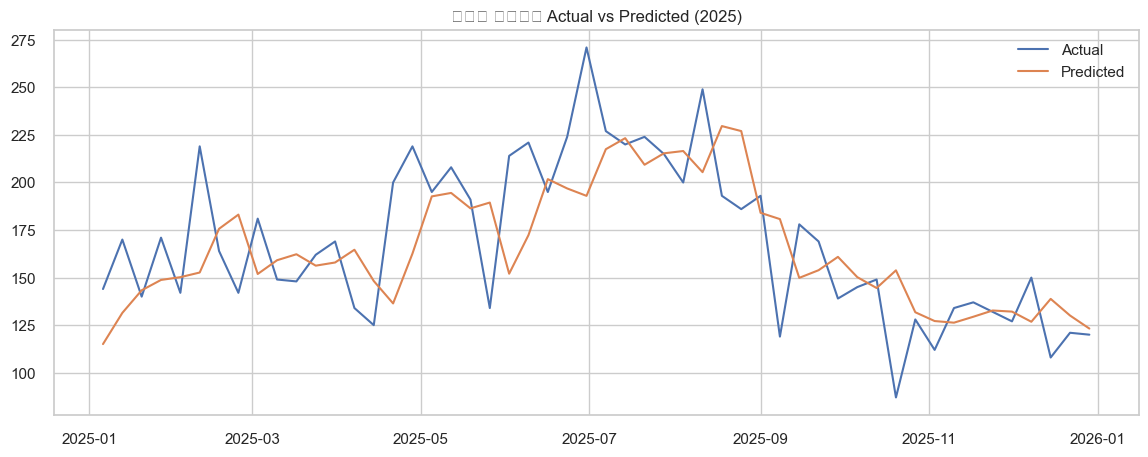

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48656 (\N{HANGUL SYLLABLE BEUN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


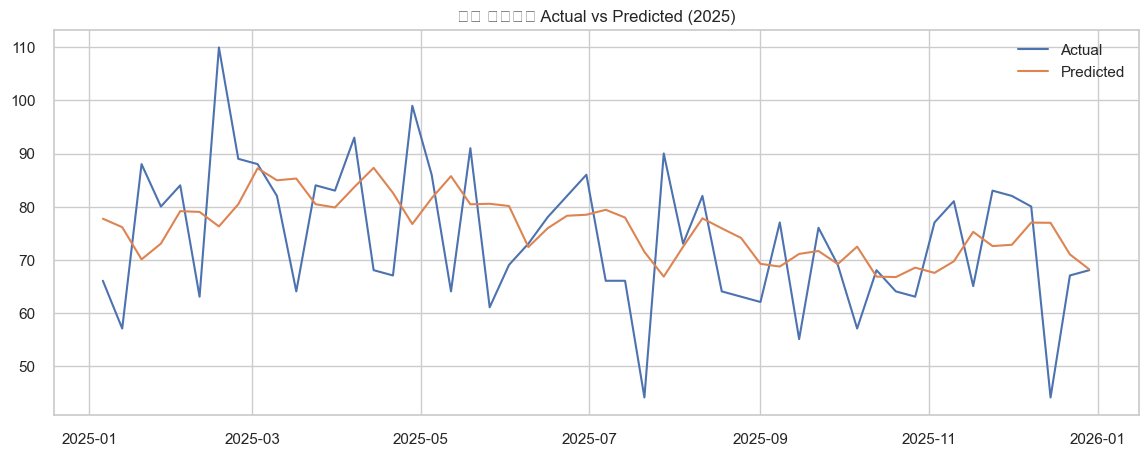

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.p

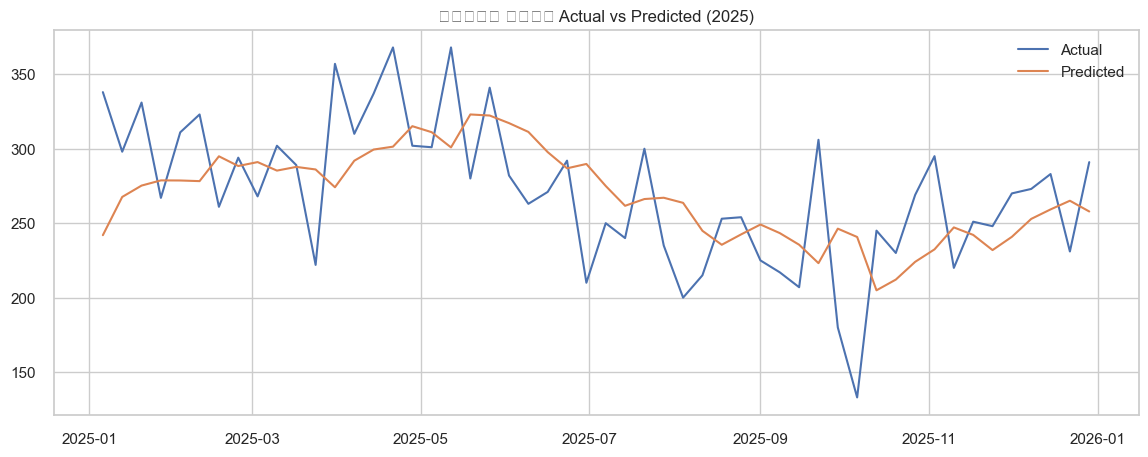

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


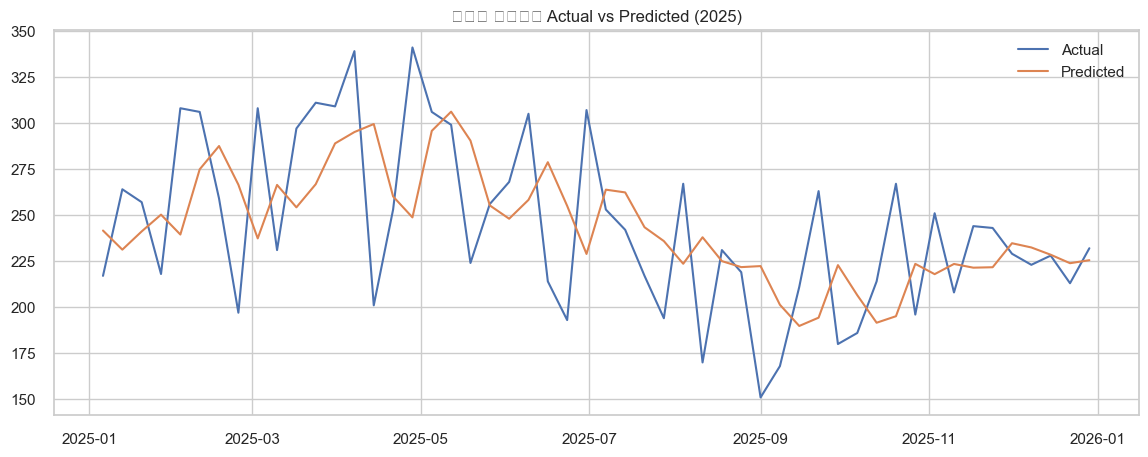

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47672 (\N{HANGUL SYLLABLE MEO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


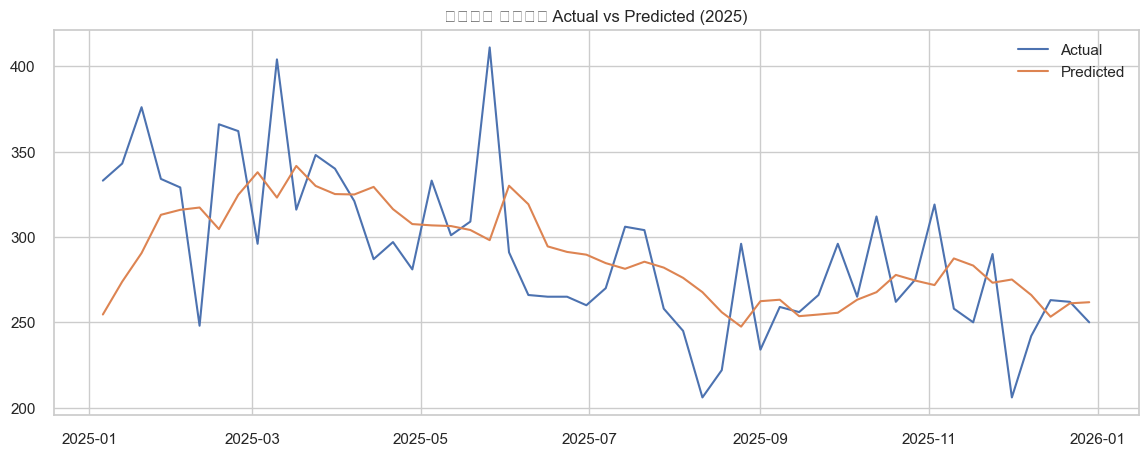

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


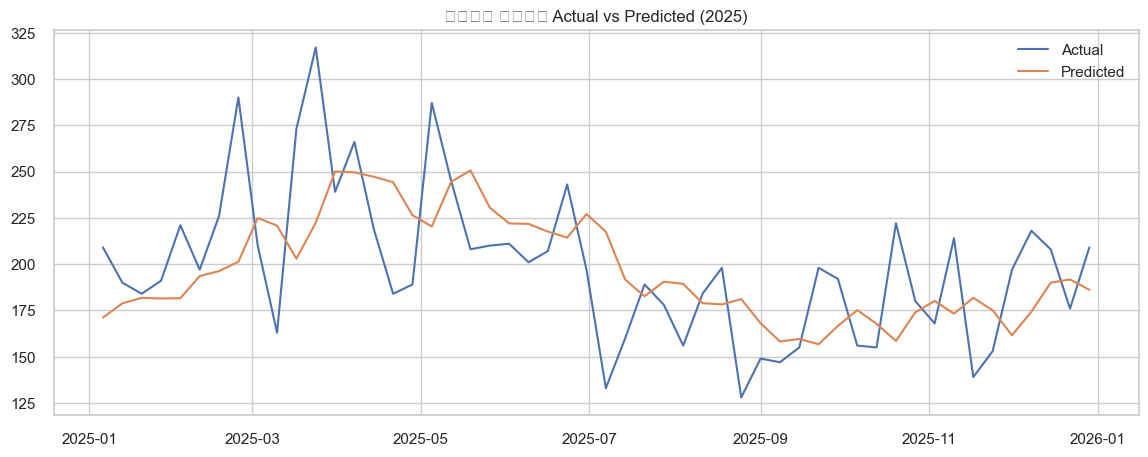

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47536 (\N{HANGUL SYLLABLE RIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


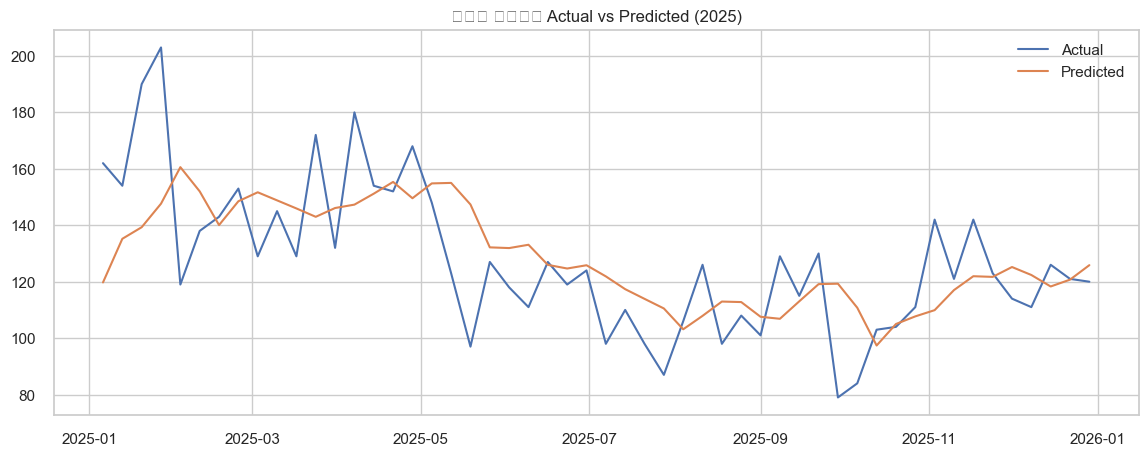

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

BASE = Path.cwd().parents[1] / "python-server" / "app" / "data_pipeline"


EVAL_DF = BASE / "eval_2025_pred_vs_actual.csv"

eval_df = pd.read_csv(EVAL_DF, parse_dates=["target_date"])

SKU_IN = BASE / "sku_catalog_ml_with_share.csv"


sku_info = pd.read_csv(SKU_IN)

df = eval_df.merge(sku_info[["sku_id","cat_low"]], on="sku_id", how="left")

cat_group = df.groupby(["cat_low","target_date"]).agg(
    actual=("y","sum"),
    pred=("y_pred","sum")
).reset_index()

for cat in cat_group["cat_low"].unique():
    g = cat_group[cat_group["cat_low"] == cat]
    plt.figure(figsize=(14,5))
    plt.plot(g["target_date"], g["actual"], label="Actual")
    plt.plot(g["target_date"], g["pred"], label="Predicted")
    plt.title(f"{cat} 카테고리 Actual vs Predicted (2025)")
    plt.legend()
    plt.show()


In [105]:
import pandas as pd
import numpy as np
BASE = Path.cwd().parents[1] / "python-server" / "app" / "data_pipeline"

df = pd.read_csv(BASE/"eval_2025_pred_vs_actual.csv")


print(df.head())

print("std:", df["y_pred"].std())
print("unique:", df["y_pred"].nunique())


  target_date  sku_id   y     y_pred
0  2025-01-06       1  47  46.777836
1  2025-01-13       1  45  45.729067
2  2025-01-20       1  34  45.176108
3  2025-01-27       1  43  42.295144
4  2025-02-03       1  43  42.531341
std: 29.483309867353896
unique: 7197


In [106]:
import random
sample_skus = random.sample(list(df["sku_id"].unique()), 5)

for sku in sample_skus:
    temp = df[df["sku_id"] == sku].sort_values("target_date").head(10)
    print("\n### SKU:", sku)
    print(temp[["target_date","y","y_pred"]])



### SKU: 108
     target_date   y     y_pred
5564  2025-01-06  39  29.619221
5565  2025-01-13  40  31.987543
5566  2025-01-20  45  33.536026
5567  2025-01-27  40  35.999758
5568  2025-02-03  40  37.233293
5569  2025-02-10  30  37.439279
5570  2025-02-17  45  36.941226
5571  2025-02-24  44  39.127124
5572  2025-03-03  36  41.407172
5573  2025-03-10  49  39.288324

### SKU: 36
     target_date  y    y_pred
1820  2025-01-06  1  1.318018
1821  2025-01-13  2  1.318018
1822  2025-01-20  1  1.414051
1823  2025-01-27  1  1.429821
1824  2025-02-03  2  1.345004
1825  2025-02-10  2  1.414051
1826  2025-02-17  1  1.544220
1827  2025-02-24  2  1.475174
1828  2025-03-03  1  1.583467
1829  2025-03-10  2  1.599238

### SKU: 81
     target_date   y     y_pred
4160  2025-01-06  49  34.302918
4161  2025-01-13  44  39.451670
4162  2025-01-20  49  39.279269
4163  2025-01-27  39  40.808868
4164  2025-02-03  47  39.828785
4165  2025-02-10  48  41.897281
4166  2025-02-17  39  43.882714
4167  2025-02-24  45  

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools

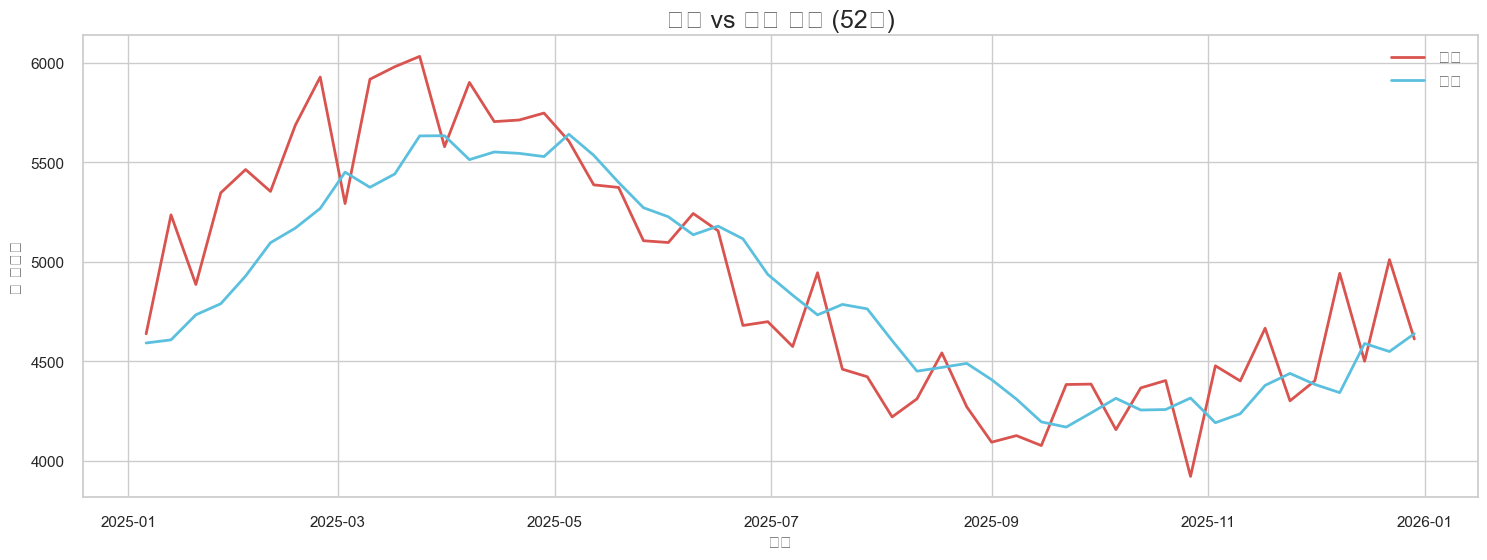

C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48656 (\N{HANGUL SYLLABLE BEUN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53441 (\N{HANGUL SYLLABLE TAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.p

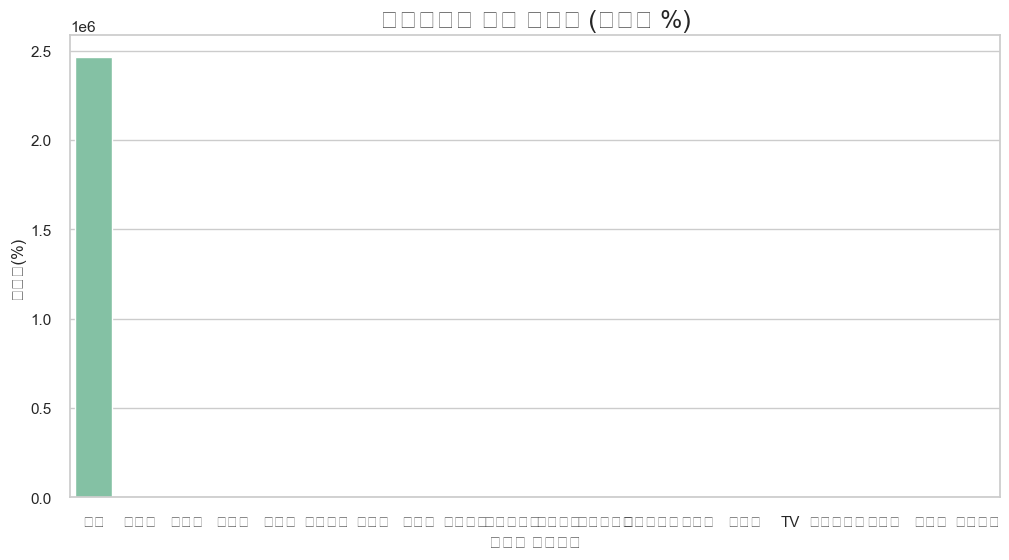

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")

# ==========================
# 1) CSV 로드
# ==========================
BASE = Path.cwd().parents[1] / "python-server" / "app" / "data_pipeline"

EVAL = BASE / "eval_2025_pred_vs_actual.csv"
SKU = BASE / "sku_catalog_ml_with_share.csv"

df = pd.read_csv(EVAL, parse_dates=["target_date"])
sku = pd.read_csv(SKU)

# SKU 정보 병합
df = df.merge(sku[["sku_id", "cat_low"]], on="sku_id", how="left")

# ==========================
# 2) 전체 예측 vs 실제 (주차별 SUM)
# ==========================
ts = (
    df.groupby("target_date")[["y", "y_pred"]]
      .sum()
      .reset_index()
)

plt.figure(figsize=(18,6))
plt.plot(ts["target_date"], ts["y"], label="실제", color="#d9534f", linewidth=2)
plt.plot(ts["target_date"], ts["y_pred"], label="예측", color="#5bc0de", linewidth=2)

plt.title("예측 vs 실제 수요 (52주)", fontsize=18)
plt.xlabel("날짜", fontsize=12)
plt.ylabel("총 수요량", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# ==========================
# 3) 카테고리별 오차율(MAPE)
# ==========================
df["mape"] = np.abs(df["y"] - df["y_pred"]) / (df["y"] + 1e-6)

cat_mape = (
    df.groupby("cat_low")["mape"]
      .mean()
      .reset_index()
      .sort_values("mape", ascending=False)
)

cat_mape["오차율(%)"] = cat_mape["mape"] * 100

plt.figure(figsize=(12,6))
sns.barplot(data=cat_mape, x="cat_low", y="오차율(%)", color="#7acba5")

plt.title("카테고리별 예측 정확도 (오차율 %)", fontsize=18)
plt.xlabel("중분류 카테고리", fontsize=12)
plt.ylabel("오차율(%)", fontsize=12)

plt.show()


In [132]:
import pandas as pd
import joblib
from catboost import CatBoostRegressor
from pathlib import Path
import json 
BASE = Path.cwd().parents[1] / "python-server" / "app" / "data_pipeline"

df = pd.read_csv(BASE/"features_all.csv", parse_dates=["target_date"])

# train / test split
train = df[df["target_date"] < "2025-01-01"].copy()
test  = df[df["target_date"] >= "2025-01-01"].copy()

# features
with open(BASE/"lightgbm_features.json") as f:
    features = json.load(f)

X_test = test[features]
y_test = test["actual_order_qty"]

# load models
lgb = joblib.load(BASE/"lightgbm_model.pkl")

cat = CatBoostRegressor()
cat.load_model(BASE/"catboost_model.pkl")

pred_lgb = lgb.predict(X_test)
pred_cat = cat.predict(X_test)

print("Std difference:", (pred_lgb - pred_cat).std())
print("Mean difference:", (pred_lgb - pred_cat).mean())


Std difference: 1.4196881122292249
Mean difference: -0.05396444414903172


In [119]:
!pip install catboost


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
